### **Import Libraries**

In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *

### **Load and Merge Datasets**

In [104]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

data = transactions.merge(customers, on="CustomerID")

# Aggregate features for clustering
agg_features = data.groupby("CustomerID").agg({
    "TotalValue": "mean",
    "TransactionID": "count",
    "Quantity": "mean",
}).rename(columns={
    "TotalValue": "AvgTransactionValue",
    "TransactionID": "TransactionCount",
    "Quantity": "AvgQuantity"
})

# Merge aggregated features with customer profiles
profile_features = customers.set_index("CustomerID")
final_features = profile_features.join(agg_features)
final_features = final_features.drop(columns=["CustomerName", "SignupDate"], errors='ignore')

In [105]:
final_features.head()

,Region,AvgTransactionValue,TransactionCount,AvgQuantity
CustomerID,,,,
C0001,South America,670.904,5.0,2.400000
C0002,Asia,465.685,4.0,2.500000
C0003,South America,681.345,4.0,3.500000
C0004,South America,669.360,8.0,2.875000
C0005,Asia,678.080,3.0,2.333333


### **Pre-Processing Data**

**1. Handling Missing Values**

In [106]:
final_features.isnull().sum()

Region                 0
AvgTransactionValue    1
TransactionCount       1
AvgQuantity            1
dtype: int64

In [107]:
# Separate numeric and non-numeric columns
numeric_columns = final_features.select_dtypes(include=["number"]).columns
non_numeric_columns = final_features.select_dtypes(exclude=["number"]).columns

# Fill missing values in numeric columns with the mean
final_features[numeric_columns] = final_features[numeric_columns].fillna(final_features[numeric_columns].mean())

# Optionally, fill missing values in non-numeric columns with a placeholder
final_features[non_numeric_columns] = final_features[non_numeric_columns].fillna("Unknown")


In [108]:
final_features

,Region,AvgTransactionValue,TransactionCount,AvgQuantity
CustomerID,,,,
C0001,South America,670.904000,5.0,2.400000
C0002,Asia,465.685000,4.0,2.500000
C0003,South America,681.345000,4.0,3.500000
C0004,South America,669.360000,8.0,2.875000
C0005,Asia,678.080000,3.0,2.333333
...,...,...,...,...
C0196,Europe,1245.720000,4.0,3.000000
C0197,Europe,642.883333,3.0,3.000000
C0198,Europe,465.915000,2.0,1.500000


**2. Encode Categorical Values**

In [109]:
final_features_encoded = pd.get_dummies(final_features, columns=["Region"], drop_first=True)

**3. Standardize Numerical Features**

In [110]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features_encoded)

### **Applying K-means Clustering**

In [141]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

final_features_encoded["Cluster"] = clusters

### **Evaluating Cluster on the basis of db-index**

In [142]:
db_index = davies_bouldin_score(scaled_features, clusters)
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 1.1933243678801064


In [143]:
print(kmeans.cluster_centers_)

[[ 0.27934692  1.19161919  0.24436459 -0.45580284 -0.54653573 -0.64686916]
 [ 0.01654289 -0.80689393 -0.10608591 -0.57735027 -0.54653573 -0.64686916]
 [ 0.05528071  0.05825243  0.0848292  -0.57735027 -0.54653573  1.54590766]
 [-0.20116055  0.1276549  -0.11425342 -0.57735027  1.82970656 -0.64686916]
 [ 0.00484845 -0.20742137 -0.03118109  1.73205081 -0.54653573 -0.64686916]]


In [144]:
print(kmeans.inertia_)

551.3923607446752


In [145]:
cluster_sizes = pd.Series(final_features_encoded["Cluster"]).value_counts()
print(cluster_sizes)

Cluster
2    59
4    49
3    46
1    27
0    19
Name: count, dtype: int64


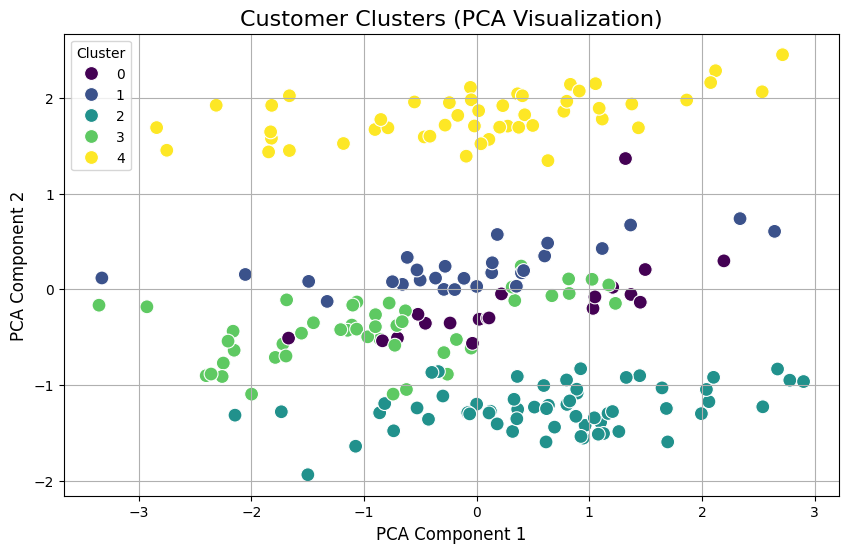

In [149]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

final_features_encoded["PCA1"] = reduced_features[:, 0]
final_features_encoded["PCA2"] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", 
    y="PCA2", 
    hue="Cluster",
    data=final_features_encoded, 
    palette="viridis",
    s=100
)
plt.title("Customer Clusters (PCA Visualization)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()